# Set up

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import xrft
from torch.utils.data import DataLoader, TensorDataset
from utils import *
from train_v1 import *
from loss import *
from UNET import *

In [2]:
base_path = "gs://leap-persistent/YueWang/SSH/data"

def open_zarr(path):
    return xr.open_zarr(path, consolidated=True)

train = open_zarr(f"{base_path}/train_80.zarr").compute()
val = open_zarr(f"{base_path}/val_80.zarr").compute()
test = open_zarr(f"{base_path}/test_80.zarr").compute()
zca = open_zarr(f"{base_path}/zca_80.zarr").compute()

In [3]:
train

<xarray.Dataset> Size: 6GB
Dimensions:  (sample: 43740, i: 80, j: 80)
Coordinates:
  * j        (j) int64 640B 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
  * sample   (sample) int64 350kB 0 1 2 3 4 5 ... 43735 43736 43737 43738 43739
  * i        (i) int64 640B 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
Data variables:
    bm       (sample, i, j) float32 1GB nan nan nan nan nan ... nan nan nan nan
    zca_ubm  (sample, i, j) float32 1GB nan nan nan nan nan ... nan nan nan nan
    zca_bm   (sample, i, j) float32 1GB nan nan nan nan nan ... nan nan nan nan
    ssh      (sample, i, j) float32 1GB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ubm      (sample, i, j) float32 1GB nan nan nan nan nan ... nan nan nan nan

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
y_train = torch.from_numpy(train.zca_ubm.values).float().unsqueeze(1).to(device)

x_val = torch.from_numpy(val.ssh.values).float().unsqueeze(1).to(device)
y_val = torch.from_numpy(val.ubm.values).float().unsqueeze(1).to(device)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

zca_Vt_ubm = torch.from_numpy(zca.zca_Vt_ubm.values).float().to(device)
zca_mean_ubm = torch.from_numpy(zca.zca_mean_ubm.values).float().to(device)
zca_scale_ubm = torch.from_numpy(zca.zca_scale_ubm.values).float().to(device)

# Training

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

loss_train = GaussianLoss()
loss_val = MseLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, val_loader,
            zca_Vt_ubm, zca_scale_ubm, zca_mean_ubm,
            loss_train, loss_val,
            optimizer, device,
            probabilistic=True,
            save_path ='/home/jovyan/GRL/checkpoint/zca_only.pth',
            n_epochs = 2000, 
            patience = 50)

/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/jovyan/GRL/train_v1.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full 

Resuming from epoch 1 with best_val_loss = 1.849e-04
Epoch 2, Train Loss: -1.46e-01, Val Loss: 1.06e-04, Epoch Time: 110.85s
Best model so far saved at epoch 2 (Val Loss: 1.062e-04)
Epoch 3, Train Loss: -1.78e-01, Val Loss: 8.41e-05, Epoch Time: 110.06s
Best model so far saved at epoch 3 (Val Loss: 8.406e-05)
Epoch 4, Train Loss: -1.96e-01, Val Loss: 8.18e-05, Epoch Time: 110.18s
Best model so far saved at epoch 4 (Val Loss: 8.182e-05)
Epoch 5, Train Loss: -2.12e-01, Val Loss: 6.96e-05, Epoch Time: 110.12s
Best model so far saved at epoch 5 (Val Loss: 6.958e-05)
Epoch 6, Train Loss: -2.26e-01, Val Loss: 8.05e-05, Epoch Time: 110.11s
Patience counter: 1/50
Epoch 7, Train Loss: -2.38e-01, Val Loss: 6.72e-05, Epoch Time: 110.17s
Best model so far saved at epoch 7 (Val Loss: 6.721e-05)
Epoch 8, Train Loss: -2.46e-01, Val Loss: 7.42e-05, Epoch Time: 110.15s
Patience counter: 1/50
Epoch 9, Train Loss: -2.53e-01, Val Loss: 6.68e-05, Epoch Time: 110.23s
Best model so far saved at epoch 9 (Val 

# Testing

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

x_test = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def inverse_zca_transform_torch(data_zca, Vt, scale, data_mean):
    """
    Inverse ZCA transformation in PyTorch (GPU-compatible).
    """
    num_images, img_rows, img_cols = data_zca.shape
    D = img_rows * img_cols
    data_zca_flat = data_zca.view(num_images, D)
    
    # Handle NaNs by imputing with 0 (mean in original space)
    mask = ~torch.isnan(data_zca_flat)
    data_zca_flat_clean = torch.where(mask, data_zca_flat, torch.zeros_like(data_zca_flat))
    
    # Step 1: Project to PCA space
    transformed = torch.matmul(data_zca_flat_clean, Vt.T)
    # Step 2: Undo scaling
    rescaled = transformed / scale
    # Step 3: Project back to original space
    original_centered = torch.matmul(rescaled, Vt)
    data_reconstructed_flat = original_centered + data_mean
    
    # Restore NaNs and reshape
    data_reconstructed_flat[~mask] = torch.nan
    return data_reconstructed_flat.view(num_images, img_rows, img_cols)

def inverse_zca_variance_torch(var_zca, Vt, scale):
    """
    Propagate variance through inverse ZCA in PyTorch.
    """
    num_images, img_rows, img_cols = var_zca.shape
    D = img_rows * img_cols
    var_zca_flat = var_zca.view(num_images, D)
    
    # Step 1: Project variance through Vt.T
    var_step1 = torch.matmul(var_zca_flat, (Vt.T ** 2))
    # Step 2: Scale variance
    var_step2 = var_step1 / (scale ** 2)
    # Step 3: Project variance through Vt
    var_data_flat = torch.matmul(var_step2, (Vt ** 2))
    
    return var_data_flat.view(num_images, img_rows, img_cols)

def inverse_zca_transform_sigma_torch(sigma_zca, Vt, scale):
    """
    Propagate standard deviation through inverse ZCA in PyTorch.
    """
    var_zca = sigma_zca ** 2
    var_data = inverse_zca_variance_torch(var_zca, Vt, scale)
    return torch.sqrt(var_data)
    
def evaluate_model_zca(model, device, test_loader, Vt, scale, data_mean, ssh_test, checkpoint_path, probabilistic=False):
    model = model.to(device)
    model.eval()
    eps = 1e-6

    # Load checkpoint
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint at {checkpoint_path}")

    # Convert ZCA params to PyTorch tensors on the same device
    Vt_tensor = torch.from_numpy(Vt).float().to(device)
    scale_tensor = torch.from_numpy(scale).float().to(device)
    data_mean_tensor = torch.from_numpy(data_mean).float().to(device)

    # Collect predictions
    mu_zca_list, sigma_zca_list = [], []
    
    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            
            if probabilistic:
                mu = outputs[:, 0, ...]
                log_sigma = outputs[:, 1, ...]
                sigma = torch.exp(log_sigma).clamp(min=eps)
                mu_zca_list.append(mu)
                sigma_zca_list.append(sigma)
            else:
                mu_zca_list.append(outputs)

    # Process outputs
    mu_zca = torch.cat(mu_zca_list, dim=0)
    if probabilistic:
        sigma_zca = torch.cat(sigma_zca_list, dim=0)
        # Propagate uncertainty on GPU
        sigma_ubm = inverse_zca_transform_sigma_torch(sigma_zca, Vt_tensor, scale_tensor)
        sigma_ubm_np = sigma_ubm.cpu().numpy()
        sigma_zca_np = sigma_zca.cpu().numpy()
    else:
        sigma_zca = None
        sigma_ubm_np = None

    # Invert ZCA for mean prediction
    ubm_prediction = inverse_zca_transform_torch(mu_zca, Vt_tensor, scale_tensor, data_mean_tensor)
    ubm_prediction_np = ubm_prediction.cpu().numpy()
    
    # Convert to xarray DataArrays (assuming `xr_da` handles numpy inputs)
    mu_zca_da = xr_da(mu_zca.cpu().numpy(), ssh_test)
    sigma_zca_da = xr_da(sigma_zca_np, ssh_test) if probabilistic else None
    sigma_ubm_da = xr_da(sigma_ubm_np, ssh_test) if probabilistic else None
    ubm_da = xr_da(ubm_prediction_np, ssh_test)
    bm_da = ssh_test - ubm_da

    return mu_zca_da, sigma_zca_da, sigma_ubm_da, ubm_da, bm_da

mu_zca, sigma_zca, sigma_ubm, mu_ubm, mu_bm = evaluate_model_zca(
    UNet(in_channels=1, out_channels=2, initial_features=32, depth=4), device, test_loader,
    zca.zca_Vt_ubm.values, zca.zca_scale_ubm.values, zca.zca_mean_ubm.values,
    test.ssh,
    '/home/jovyan/GRL/checkpoint/eps9.pth',
    probabilistic=True
)


/tmp/ipykernel_50/721267133.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from /home/jovyan/GRL/checkpoint/eps9.pth


# ZCA

In [23]:
def calculate_psd(data):
    """Calculate PSD for a given data array."""
    data_da = xr.DataArray(
        data,
        dims=['i', 'j'],
        coords={'i': range(data.shape[0]), 'j': range(data.shape[1])}
    )
    return isotropic_spectra(data_da)

ubm = train.ubm.isel(sample=155).values
zca = train.zca_ubm.isel(sample=155).values
psd_ubm = calculate_psd(ubm)
psd_zca = calculate_psd(zca)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


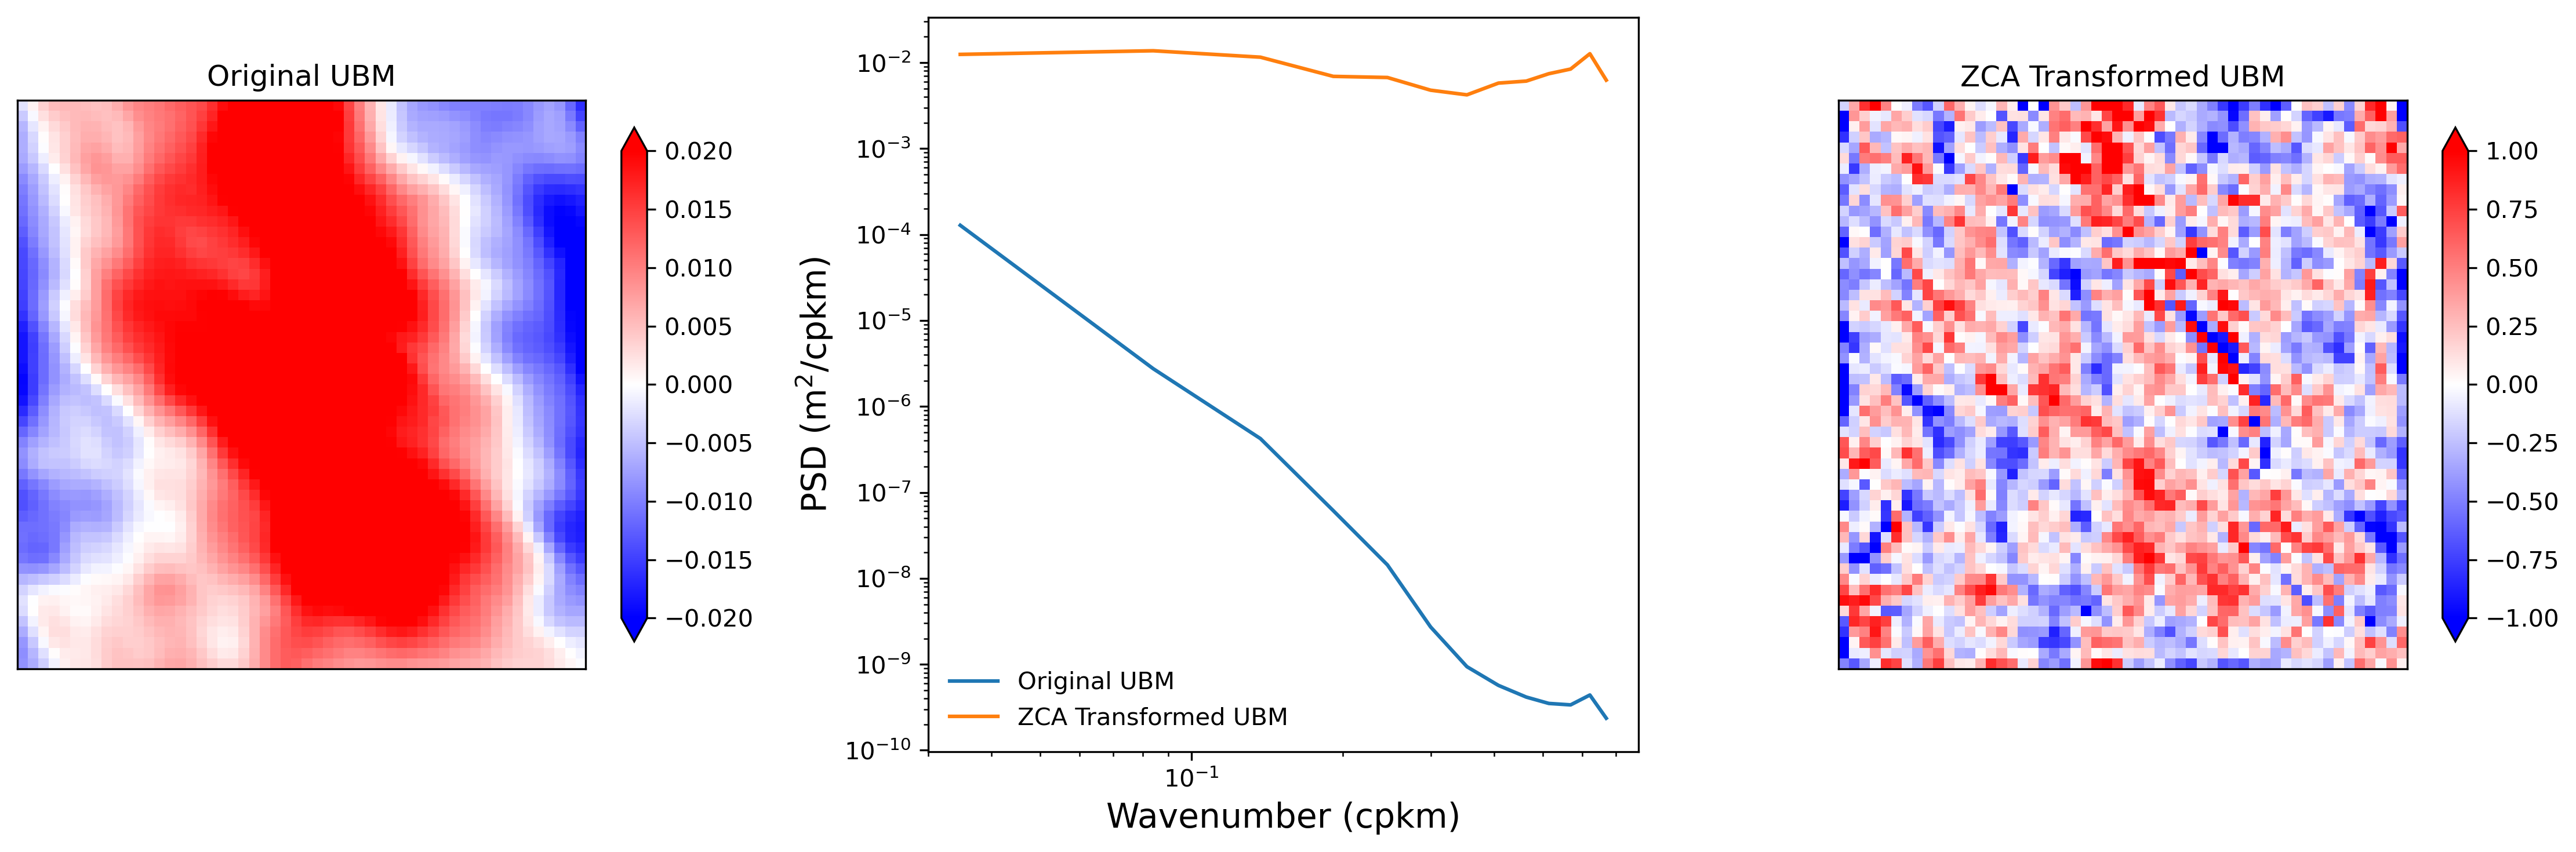

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(ubm, zca, psd_ubm, psd_zca):
    """
    Create a 1x3 subplot comparing UBM, PSD, and ZCA
    
    Parameters:
    -----------
    ubm : numpy.ndarray
        2D array of UBM data
    zca : numpy.ndarray
        2D array of ZCA data
    psd_ubm : xarray.DataArray
        PSD of UBM data
    psd_zca : xarray.DataArray
        PSD of ZCA data
    """
    
    # Create figure with 3 subplots and dpi=300
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
    
    # Plot UBM on the left
    im1 = ax1.imshow(ubm, cmap='bwr', vmin=-0.02, vmax=0.02)
    ax1.set_title('Original UBM')
    # Remove ticks
    ax1.set_xticks([])
    ax1.set_yticks([])
    # Colorbar with extend on both ends
    plt.colorbar(im1, ax=ax1, shrink=0.7, extend='both')
    
    # Plot PSDs in the center (log-log scale)
    ax2.loglog(psd_ubm.freq_r, psd_ubm.values, label='Original UBM')
    ax2.loglog(psd_zca.freq_r, psd_zca.values, label='ZCA Transformed UBM')

    # Larger x and y labels
    ax2.set_xlabel(r'Wavenumber (cpkm)', fontsize=14)
    ax2.set_ylabel(r'PSD ($\mathrm{m}^2$/cpkm)', fontsize=14)
    # Legend without a box
    ax2.legend(frameon=False)
    ax2.grid(False)
    
    # Plot ZCA on the right
    im2 = ax3.imshow(zca, cmap='bwr', vmin=-1, vmax=1)
    ax3.set_title('ZCA Transformed UBM')
    # Remove ticks
    ax3.set_xticks([])
    ax3.set_yticks([])
    # Colorbar with extend on both ends
    plt.colorbar(im2, ax=ax3, shrink=0.7, extend='both')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig


fig = plot_comparison(ubm, zca, psd_ubm, psd_zca)
plt.show()


In [9]:
mask = test.ubm.isnull().any(dim=['i', 'j'])

def remove_nan_samples(da, mask):
    return da.isel(sample=~mask)

ubm_true_clean = remove_nan_samples(test.ubm, mask)
ubm_pre_clean = remove_nan_samples(mu_ubm, mask)
ubm_uncertainty_clean = remove_nan_samples(sigma_ubm, mask)

bm_true_clean = remove_nan_samples(test.bm, mask)
bm_pre_clean = remove_nan_samples(mu_bm, mask)

ssh_clean = remove_nan_samples(test.ssh, mask)

mu_zca_clean = remove_nan_samples(mu_zca, mask)
sigma_zca_clean = remove_nan_samples(sigma_zca, mask)

In [10]:
def find_smallest_relative_error_indices(true_array, pred_array):
   # Calculate mean squared error per sample
   mse_per_sample = ((true_array - pred_array) ** 2).mean(axis=(1,2))
   
   # Calculate mean squared magnitude of true values per sample
   magnitude_per_sample = (true_array ** 2).mean(axis=(1,2))
   
   # Calculate relative error (MSE divided by magnitude)
   # Add small epsilon to avoid division by zero
   epsilon = 0
   relative_error = mse_per_sample / (magnitude_per_sample + epsilon)
   

   best_indices = np.argsort(relative_error)[:30]
    
   worst_indices = np.argsort(relative_error)[-30:]
   
   return best_indices, worst_indices
    
best_indices, worst_indices = find_smallest_relative_error_indices(ubm_true_clean, ubm_pre_clean)

In [11]:
best_indices

<xarray.DataArray (sample: 30)> Size: 240B
array([4312,   67, 5925,  179, 4809, 5885, 4583,  974, 4543, 5998, 6116,
        750, 3200, 1519, 1786,  740, 2313,  935, 5812,  937, 3013, 3088,
       5811, 4283, 2274, 2891, 1747, 3127, 5653, 1520])
Coordinates:
  * sample   (sample) int64 240B 41 42 43 44 45 46 47 ... 64 65 66 67 68 69 70

In [12]:
worst_indices

<xarray.DataArray (sample: 30)> Size: 240B
array([ 831, 6310, 4927, 5037, 2093, 2643, 1015, 1111, 6181, 2354, 2081,
       6661, 6247, 1137, 5004, 1317, 4889, 4659,  697,  754, 1167,  317,
       4774, 4837, 1658, 2036, 3496, 6532, 3849, 1166])
Coordinates:
  * sample   (sample) int64 240B 7905 7906 7907 7908 ... 7948 7949 7950 7951

In [13]:
import numpy as np
from scipy.stats import pearsonr
import xarray as xr

def find_best_worst_correlation_indices(true_array, pred_array):
    """
    Find indices of samples with highest and lowest correlation between true and predicted values.
    Works with xarray DataArrays.
    
    Parameters:
    true_array: xarray DataArray of true values 
    pred_array: xarray DataArray of predicted values
    
    Returns:
    best_indices: Indices of 30 samples with highest correlation
    worst_indices: Indices of 30 samples with lowest correlation
    correlations: Array of correlation values for all samples
    """
    n_samples = len(true_array.sample)
    correlations = np.zeros(n_samples)
    
    # Calculate correlation for each sample
    for i in range(n_samples):
        # Get numpy arrays from the DataArrays for this sample
        true_values = true_array.isel(sample=i).values
        pred_values = pred_array.isel(sample=i).values
        
        # Flatten the 2D numpy arrays to 1D for correlation calculation
        true_flat = true_values.flatten()
        pred_flat = pred_values.flatten()
        
        # Calculate Pearson correlation coefficient
        # Handle potential warnings or errors with try-except
        try:
            corr, _ = pearsonr(true_flat, pred_flat)
            # Handle NaN values that might occur
            if np.isnan(corr):
                correlations[i] = -1  # Assign a low value to NaN correlations
            else:
                correlations[i] = corr
        except Exception as e:
            print(f"Error calculating correlation for sample {i}: {e}")
            correlations[i] = -1  # Assign a low value if correlation calculation fails
    
    # Find indices of highest correlations (best samples)
    best_indices = np.argsort(correlations)[-30:][::-1]  # Sort in descending order
    
    # Find indices of lowest correlations (worst samples)
    worst_indices = np.argsort(correlations)[:30]
    
    return best_indices, worst_indices, correlations

# Usage:
best_indices, worst_indices, correlations = find_best_worst_correlation_indices(ubm_true_clean, ubm_pre_clean)

# Print some statistics
print(f"Best sample index: {best_indices[0]} with correlation: {correlations[best_indices[0]]:.4f}")
print(f"Worst sample index: {worst_indices[0]} with correlation: {correlations[worst_indices[0]]:.4f}")
print(f"Average correlation across all samples: {np.mean(correlations):.4f}")

# For debugging: Print a few sample correlations
print("\nSample correlations (index: correlation):")
for i in range(min(5, len(best_indices))):
    print(f"Best #{i+1}: {best_indices[i]}: {correlations[best_indices[i]]:.4f}")
for i in range(min(5, len(worst_indices))):
    print(f"Worst #{i+1}: {worst_indices[i]}: {correlations[worst_indices[i]]:.4f}")

Best sample index: 3127 with correlation: 0.9728
Worst sample index: 4766 with correlation: -0.7454
Average correlation across all samples: 0.4009

Sample correlations (index: correlation):
Best #1: 3127: 0.9728
Best #2: 67: 0.9678
Best #3: 2313: 0.9648
Best #4: 5925: 0.9646
Best #5: 4543: 0.9643
Worst #1: 4766: -0.7454
Worst #2: 959: -0.6453
Worst #3: 5360: -0.6325
Worst #4: 3499: -0.6195
Worst #5: 6647: -0.6189


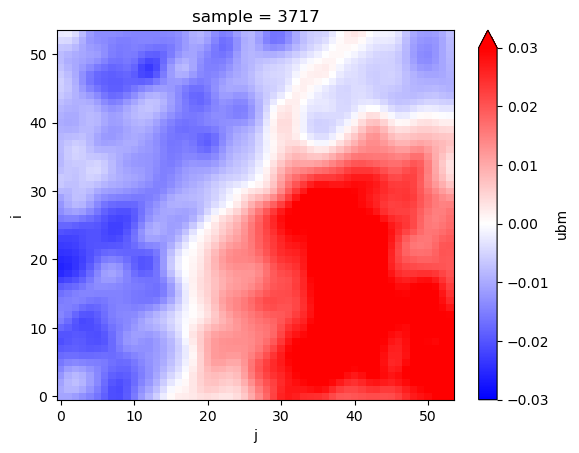

In [14]:
ubm_true_clean.isel(sample=3127).plot(cmap='bwr', vmin=-0.03, vmax=0.03)

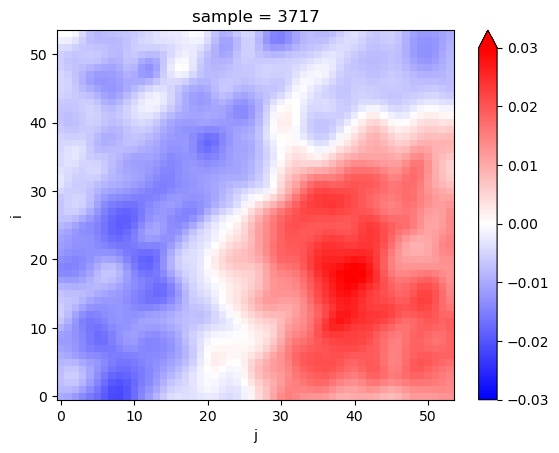

In [15]:
ubm_pre_clean.isel(sample=3127).plot(cmap='bwr', vmin=-0.03, vmax=0.03)

In [17]:
def calculate_gradient_magnitude(field):
    dy, dx = np.gradient(field)
    magnitude = np.sqrt(dx**2 + dy**2)
    return magnitude

# Best Sample

best_ssh_sample = ssh_clean.isel(sample=253).values

best_mu_zca_sample = mu_zca_clean.isel(sample=253).values
best_sigma_zca_sample = sigma_zca_clean.isel(sample=253).values

best_ubm_pre_sample = ubm_pre_clean.isel(sample=253).values
best_ubm_true_sample = ubm_true_clean.isel(sample=253).values
best_ubm_uncertainty_sample = ubm_uncertainty_clean.isel(sample=253).values
best_bm_pre_sample = bm_pre_clean.isel(sample=253).values
best_bm_true_sample = bm_true_clean.isel(sample=253).values

best_ubm_pre_grad_sample = calculate_gradient_magnitude(best_ubm_pre_sample)
best_ubm_true_grad_sample = calculate_gradient_magnitude(best_ubm_true_sample)
best_bm_pre_grad_sample = calculate_gradient_magnitude(best_bm_pre_sample)
best_bm_true_grad_sample = calculate_gradient_magnitude(best_bm_true_sample)


# Worst Sample

worst_ssh_sample = ssh_clean.isel(sample=208).values

worst_mu_zca_sample = mu_zca_clean.isel(sample=208).values
worst_sigma_zca_sample = sigma_zca_clean.isel(sample=208).values

worst_ubm_pre_sample = ubm_pre_clean.isel(sample=208).values
worst_ubm_true_sample = ubm_true_clean.isel(sample=208).values
worst_ubm_uncertainty_sample = ubm_uncertainty_clean.isel(sample=208).values
worst_bm_pre_sample = bm_pre_clean.isel(sample=208).values
worst_bm_true_sample = bm_true_clean.isel(sample=208).values

worst_ubm_pre_grad_sample = calculate_gradient_magnitude(worst_ubm_pre_sample)
worst_ubm_true_grad_sample = calculate_gradient_magnitude(worst_ubm_true_sample)
worst_bm_pre_grad_sample = calculate_gradient_magnitude(worst_bm_pre_sample)
worst_bm_true_grad_sample = calculate_gradient_magnitude(worst_bm_true_sample)


# Random Samples

np.random.seed(42)
total_samples = len(ssh_clean.sample)
random_indices = np.random.choice(total_samples, size=10, replace=False)


ubm_pre_samples = {}
ubm_true_samples = {}
ubm_uncertainty_samples = {}

# Extract data for each randomly selected sample
for i, idx in enumerate(random_indices):
    ubm_pre_samples[i] = ubm_pre_clean.isel(sample=idx).values
    ubm_true_samples[i] = ubm_true_clean.isel(sample=idx).values
    ubm_uncertainty_samples[i] = ubm_uncertainty_clean.isel(sample=idx).values

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The 

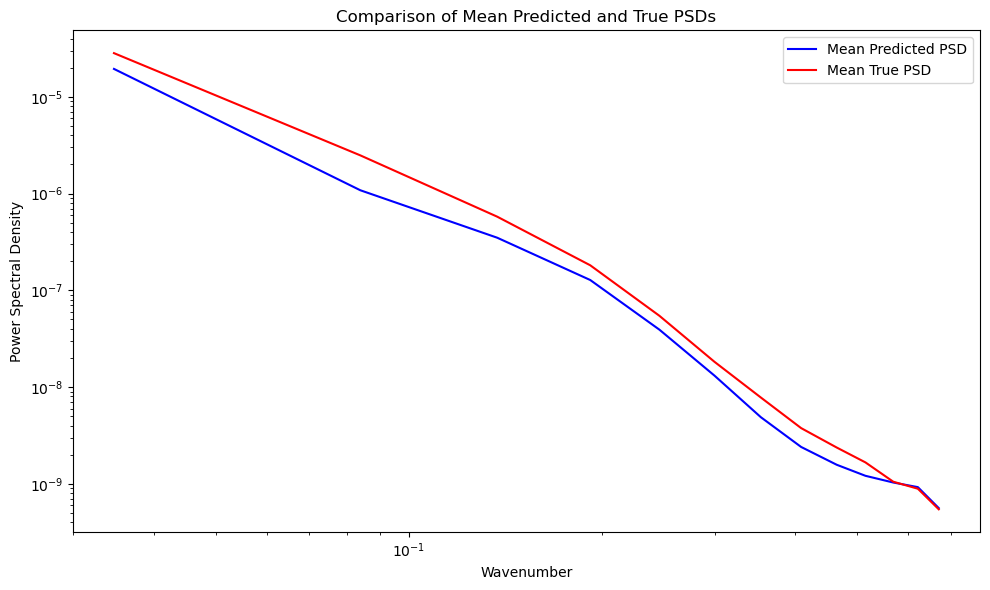

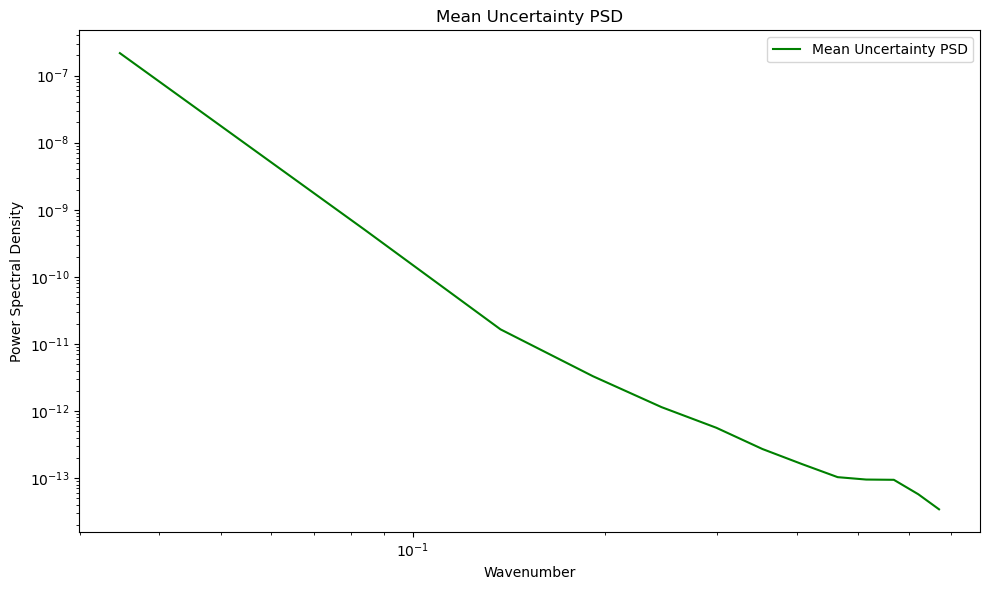

In [18]:
# Function to calculate mean PSD from a dictionary of samples
def calculate_mean_psd(samples_dict):
    """
    Calculate the mean PSD across all samples in a dictionary
    
    Parameters:
    -----------
    samples_dict : dict
        Dictionary of 2D numpy arrays
    
    Returns:
    --------
    mean_psd : xarray.DataArray
        Mean PSD across all samples
    """
    psds = []
    
    for sample_idx, array_2d in samples_dict.items():
        # Convert numpy array to xarray DataArray
        da = xr.DataArray(
            array_2d,
            dims=['i', 'j'],
            coords={'i': range(array_2d.shape[0]), 'j': range(array_2d.shape[1])}
        )
        
        # Calculate PSD
        psd = isotropic_spectra(da)
        psds.append(psd)
    
    # Combine all PSDs along a new dimension
    combined_psd = xr.concat(psds, dim='sample')
    
    # Calculate mean PSD
    mean_psd = combined_psd.mean(dim='sample')
    
    return mean_psd

# Function to plot comparison between predicted and true mean PSDs
def plot_comparison_psd(ubm_pre_samples, ubm_true_samples):
    """
    Plot comparison between mean predicted PSD and mean true PSD
    
    Parameters:
    -----------
    ubm_pre_samples : dict
        Dictionary of 2D numpy arrays for predicted samples
    ubm_true_samples : dict
        Dictionary of 2D numpy arrays for true samples
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Calculate mean PSDs
    mean_pre_psd = calculate_mean_psd(ubm_pre_samples)
    mean_true_psd = calculate_mean_psd(ubm_true_samples)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot mean PSDs
    mean_pre_psd.plot(ax=ax, color='blue', label='Mean Predicted PSD')
    mean_true_psd.plot(ax=ax, color='red', label='Mean True PSD')
    
    # Set log scales
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add labels and title
    ax.set_xlabel('Wavenumber')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title('Comparison of Mean Predicted and True PSDs')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    return fig

# Function to plot mean uncertainty PSD
def plot_uncertainty_psd(ubm_uncertainty_samples):
    """
    Plot mean uncertainty PSD
    
    Parameters:
    -----------
    ubm_uncertainty_samples : dict
        Dictionary of 2D numpy arrays for uncertainty samples
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Calculate mean uncertainty PSD
    mean_uncertainty_psd = calculate_mean_psd(ubm_uncertainty_samples)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot mean uncertainty PSD
    mean_uncertainty_psd.plot(ax=ax, color='green', label='Mean Uncertainty PSD')
    
    # Set log scales
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add labels and title
    ax.set_xlabel('Wavenumber')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title('Mean Uncertainty PSD')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    return fig

# Function to create both figures
def create_comparison_figures(ubm_pre_samples, ubm_true_samples, ubm_uncertainty_samples):
    """
    Create both PSD comparison figures
    
    Parameters:
    -----------
    ubm_pre_samples : dict
        Dictionary of 2D numpy arrays for predicted samples
    ubm_true_samples : dict
        Dictionary of 2D numpy arrays for true samples
    ubm_uncertainty_samples : dict
        Dictionary of 2D numpy arrays for uncertainty samples
    
    Returns:
    --------
    figs : list
        List of the two created figures
    """
    # Create comparison figure
    fig1 = plot_comparison_psd(ubm_pre_samples, ubm_true_samples)
    
    # Create uncertainty figure
    fig2 = plot_uncertainty_psd(ubm_uncertainty_samples)
    
    plt.show()
    return [fig1, fig2]

# Usage example:
figures = create_comparison_figures(ubm_pre_samples, ubm_true_samples, ubm_uncertainty_samples)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


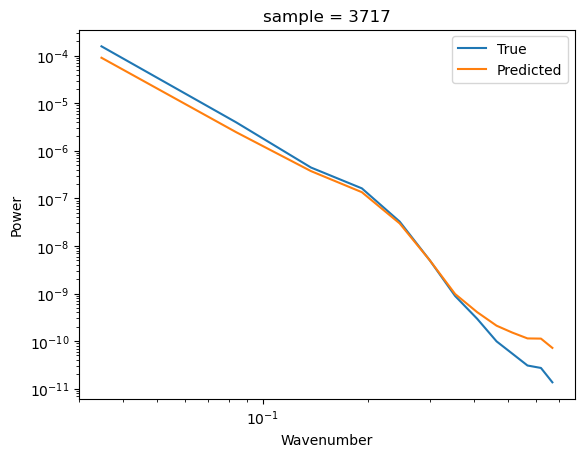

In [16]:
fig, ax = plt.subplots()

# Plot the first spectrum
isotropic_spectra(ubm_true_clean.isel(sample=3127).compute()).plot(ax=ax, xscale='log', yscale='log', label='True')

# Plot the second spectrum on the same axes
isotropic_spectra(ubm_pre_clean.isel(sample=3127).compute()).plot(ax=ax, xscale='log', yscale='log', label='Predicted')

# Set labels and legend
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power')
ax.legend()

plt.show()